In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import re

In [2]:
plt.rcParams["figure.figsize"] = (20,10)

In [30]:
path = os.getcwd()
datapath = os.path.join(path, "../../inputs/Flussrichtung_Zweige_Grundfall.csv")
data = pd.read_csv(datapath, sep=';', comment='#', header=0, skiprows=0, error_bad_lines=False, encoding='unicode_escape')
data = data.loc[:, data.columns[3:]]
colNames = []
for col in data:
    name = re.search("L-··(.*).", col)
    if not name:
        name = re.search("SO-·Standort.*(Trafo_.*)", col)
    colNames.append(name.group(1))
data.columns = colNames
data.to_pickle("../../inputs/Flussrichtung_Zweige_Grundfall.pkl")

In [3]:
def getDataFromRankCSV():
    path = os.getcwd()
    datapath = os.path.join(path, "../../inputs/New folder/Ausgabe_Zweige_rank_1.csv")
    csvList = []
    df = pd.read_csv(datapath, sep=';', comment='#', header=0, skiprows=[0,1,3,4,5], error_bad_lines=False, encoding='unicode_escape')
    csvList.append(df)
    columns = df.columns
    datapath = os.path.join(path, "../../inputs/New folder")
    fileList = [os.path.join(root, file) for root, dirs, files in os.walk(datapath) for file in files
               if not file.endswith('rank_1.csv')]
    for file in fileList:
        df = pd.read_csv(file, sep=';', comment='#', header=None, error_bad_lines=False, encoding='unicode_escape')
        df.columns = columns
        csvList.append(df)
    data = pd.concat(csvList, axis=0, ignore_index=False)
    data = data.loc[:, ['bezeichner', 'nnf', 'ausl_n0_vor', 'i_n0_vor']]
    data.columns = ['Name', 'Time_step', 'Loading_percent', 'Loading_A']
    return data

In [4]:
path = os.getcwd()
datapath = os.path.join(path, "../../inputs/Ausgabe_Zweige_1.csv")
# datapath = os.path.join(path, "../../inputs/Ausgabe_Zweige_old_1.csv")
data1 = pd.read_csv(datapath, sep=';', comment='#', header=0, skiprows=[0,1,3,4,5], error_bad_lines=False, encoding='unicode_escape', 
                   usecols=['bezeichner', 'ausl_n0_vor', 'nnf', 'i_n0_vor'])
data1.columns = ['Name', 'Time_step', 'Loading_percent', 'Loading_A']
datapath = os.path.join(path, "../../inputs/Ausgabe_Zweige_2.csv")
# datapath = os.path.join(path, "../../inputs/Ausgabe_Zweige_old_2.csv")
data2 = pd.read_csv(datapath, sep=';', comment='#', header=0, skiprows=[0,1,3,4,5], error_bad_lines=False, encoding='unicode_escape', 
                   usecols=['bezeichner', 'ausl_n0_vor', 'nnf', 'i_n0_vor'])
data2.columns = ['Name', 'Time_step', 'Loading_percent', 'Loading_A']
data3 = getDataFromRankCSV()
data = pd.concat([data1, data2, data3], axis=0, sort=False)
# data = pd.concat([data1, data2], axis=0, sort=False)
data.sort_values(by='Time_step', inplace=True)

In [5]:
# data.to_csv("../../inputs/Loading.csv", index=False)
data.to_pickle("../../inputs/Ausgabe_Zweige.pkl")

In [10]:
data.sort_values(by='Loading_percent', ascending=False)

Name  Time_step  Loading_percent  Loading_A
158893          Trafo_60       8761       419.971236  96.988202
158951          Trafo_14       8761       394.485603  56.939092
158970          Trafo_63       8761       381.954788  88.208680
158938          Trafo_48       8761       370.598799  85.586127
158965          Trafo_43       8761       359.177738  82.948546
...                  ...        ...              ...        ...
340546  Knoten_109_Stich       7171         0.000711   0.002269
84988   Knoten_109_Stich       7170         0.000711   0.002269
236851  Knoten_109_Stich       7842         0.000711   0.002269
736371  Knoten_109_Stich        706         0.000711   0.002268
393843  Knoten_109_Stich        705         0.000711   0.002267

[1924713 rows x 4 columns]

In [207]:
overloaded = data.loc[data['Loading_percent']>100, ['Name', 'Time_step', 'Loading_percent']]
overloaded.sort_values(by='Time_step', inplace=True)

In [208]:
avg_load_per_timestep = pd.DataFrame(data={'Time_step': np.arange(1, 8761),
                                          'avg_load': np.full(8760, 0, dtype=float),
                                           'avg_load_top_5_percent': np.full(8760, 0, dtype=float),
                                          'number_overload': np.full(8760, 0, dtype=int),
                                          'avg_overload': np.full(8760, 0, dtype=float)})

In [209]:
top_5_percent = round(len(data.loc[data['Time_step']==i, :])*.05)

In [210]:
for i in range(1,8761):
    avg_load_per_timestep.loc[avg_load_per_timestep['Time_step']==i, 'avg_load'] = \
    data.loc[data['Time_step']==i, 'Loading_percent'].mean(axis=0)
    avg_load_per_timestep.loc[avg_load_per_timestep['Time_step']==i, 'avg_load_top_5_percent'] = \
    data.loc[data['Time_step']==i, 'Loading_percent'].sort_values(ascending=False)[:top_5_percent].mean(axis=0)
    avg_load_per_timestep.loc[avg_load_per_timestep['Time_step']==i, 'number_overload'] = \
    overloaded.loc[overloaded['Time_step']==i].shape[0]
    avg_load_per_timestep.loc[avg_load_per_timestep['Time_step']==i, 'avg_overload'] = \
    overloaded.loc[overloaded['Time_step']==i, 'Loading_percent'].mean(axis=0)
min_loading = avg_load_per_timestep.loc[:, 'avg_load'].min()
avg_load_per_timestep.fillna(min_loading, inplace=True)

In [212]:
data

Name  Time_step  Loading_percent  \
0                                Trafo_HSMS          1         66.83039   
136                          Trafo_19_boost          1          6.45661   
137                                 L_19R_2          1         18.44538   
138                                  L_2R_2          1         18.43596   
139                                  L_3R_2          1         18.84186   
...                                     ...        ...              ...   
277697  L_Knoten_30_Stichabgang_R_Knoten_52       8760          2.52721   
277698                             Trafo_52       8760         34.96770   
277699                       L_52R_39_boost       8760          1.59704   
277689                       L_74R_39_boost       8760          2.31075   
277776                             Trafo_15       8760         23.11418   

         Loading_A  
0       3086.76332  
136        0.59644  
137       58.84077  
138       58.81072  
139       60.10555  
...            ...  
277697     8.06179  
277698     8.07545  
277699     5.09455  
277689     7.37131  
277776     8.40734  

[1768195 rows x 4 columns]

In [213]:
avg_load_per_timestep

Time_step   avg_load  avg_load_top_5_percent  number_overload  \
0             1  33.953946               92.730104                0   
1             2  37.136480               99.592938                6   
2             3  42.327255              112.551911               23   
3             4  41.909383              110.922127               23   
4             5  41.907016              111.890643               23   
...         ...        ...                     ...              ...   
8755       8756   8.990043               43.820836                0   
8756       8757   9.094410               45.013348                0   
8757       8758   8.739955               42.799806                0   
8758       8759   8.152062               38.882463                0   
8759       8760   7.960506               38.510481                0   

      avg_overload  
0         6.028279  
1       102.138390  
2       110.216969  
3       108.696367  
4       109.408343  
...            ...  
8755      6.028279  
8756      6.028279  
8757      6.028279  
8758      6.028279  
8759      6.028279  

[8760 rows x 5 columns]

In [214]:
overloaded

Name  Time_step  \
458473                                            L_0R_36          2   
458334                              Knoten_79_Stich_boost          2   
458335                            Knoten_79_Stich_boost_1          2   
458498                                      L_0R_36_boost          2   
458307                                    Knoten_79_Stich          2   
...                                                   ...        ...   
363707                                    L_0R_36_boost_1       8726   
363705  L_Knoten_25_Stichabgang_R_Knoten_18_Stichabgan...       8726   
433155                                    L_0R_36_boost_1       8729   
433154                                      L_0R_36_boost       8729   
433129                                            L_0R_36       8729   

        Loading_percent  
458473        102.85869  
458334        101.41809  
458335        101.41809  
458498        102.85869  
458307        101.41809  
...                 ...  
363707        108.10392  
363705        101.35117  
433155        100.21738  
433154        100.21738  
433129        100.21738  

[13016 rows x 3 columns]

In [254]:
with open("../../results/numCongested.pkl", "rb") as f:
    numCongested = pickle.load(f)
with open("../../results/numCongestedFull.pkl", "rb") as f:
    numCongestedFull = pickle.load(f)

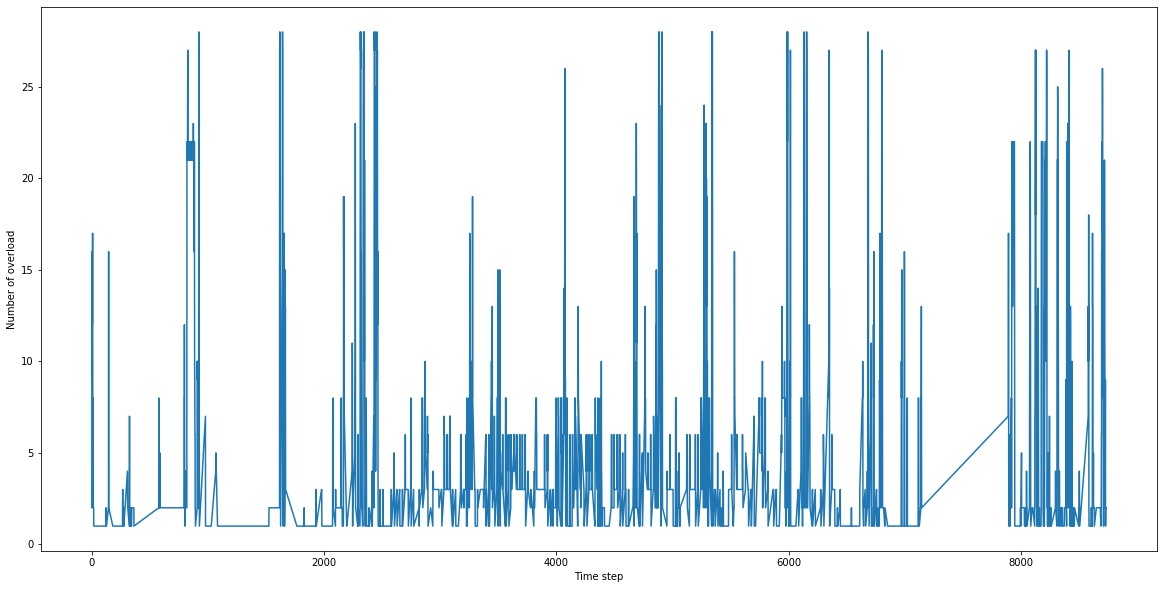

In [255]:
x = [time for (time, number) in numCongestedFull]
y = [number for (time, number) in numCongestedFull]
plt.plot(x, y)
plt.ylabel('Number of overload')
plt.xlabel('Time step')
datapath = os.path.join(path, "../../results/Loading plots/Number of overload from simulation.png")
# datapath = os.path.join(path, "../../results/Loading plots old sensis/Number of overload.png")
# plt.savefig(datapath)
plt.show()

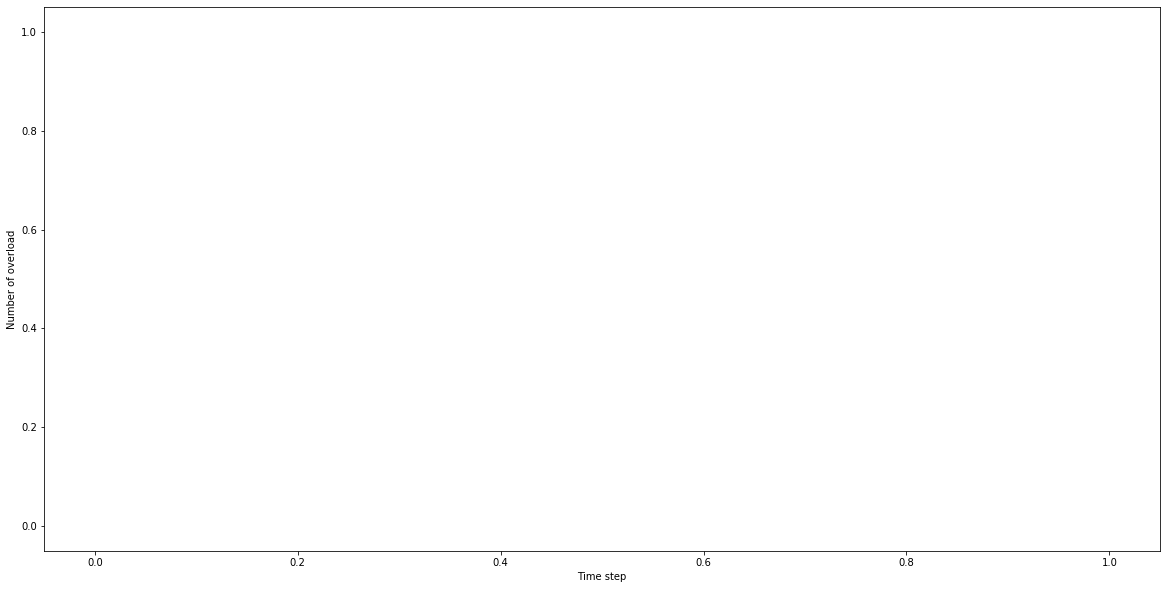

In [256]:
x = [time for (time, number) in numCongested]
y = [number for (time, number) in numCongested]
plt.plot(x, y)
plt.ylabel('Number of overload')
plt.xlabel('Time step')
# # datapath = os.path.join(path, "../../results/Loading plots/Number of overload.png")
# datapath = os.path.join(path, "../../results/Loading plots old sensis/Number of overload.png")
# plt.savefig(datapath)
plt.show()

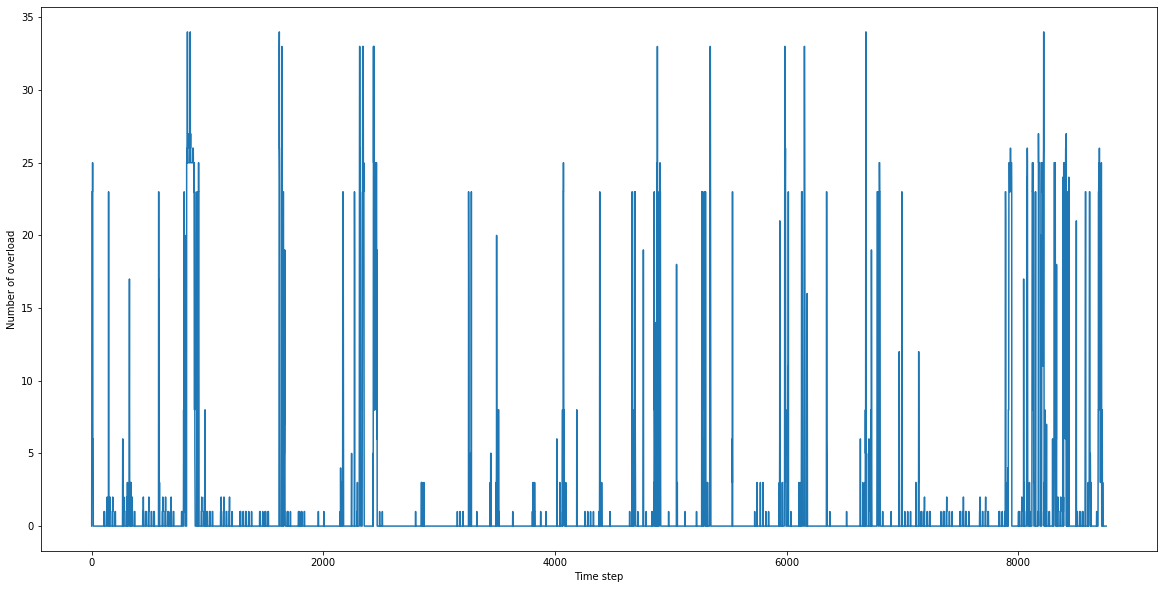

In [228]:
plt.plot(avg_load_per_timestep['Time_step'], avg_load_per_timestep['number_overload'])
plt.ylabel('Number of overload')
plt.xlabel('Time step')
# datapath = os.path.join(path, "../../results/Loading plots/Number of overload.png")
datapath = os.path.join(path, "../../results/Loading plots old sensis/Number of overload.png")
plt.savefig(datapath)
plt.show()

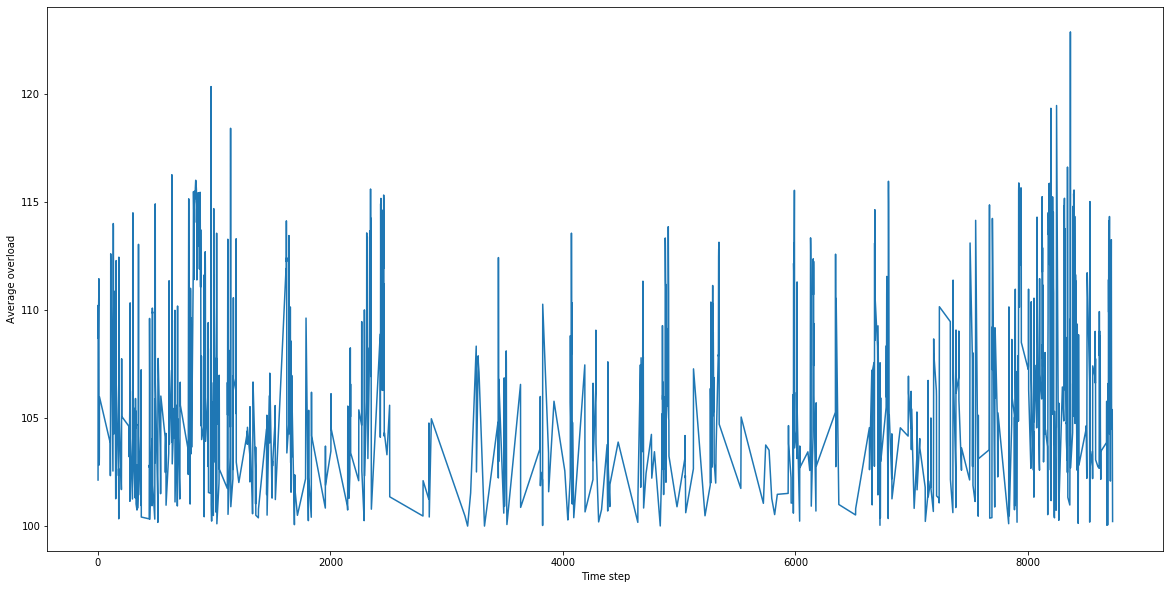

In [216]:
x = avg_load_per_timestep.loc[avg_load_per_timestep['avg_overload']>min_loading, 'Time_step']
y = avg_load_per_timestep.loc[avg_load_per_timestep['avg_overload']>min_loading, 'avg_overload']
plt.plot(x, y)
plt.ylabel('Average overload')
plt.xlabel('Time step')
# datapath = os.path.join(path, "../../results/Loading plots/Average overload.png")
datapath = os.path.join(path, "../../results/Loading plots old sensis/Average overload.png")
plt.savefig(datapath)
plt.show()

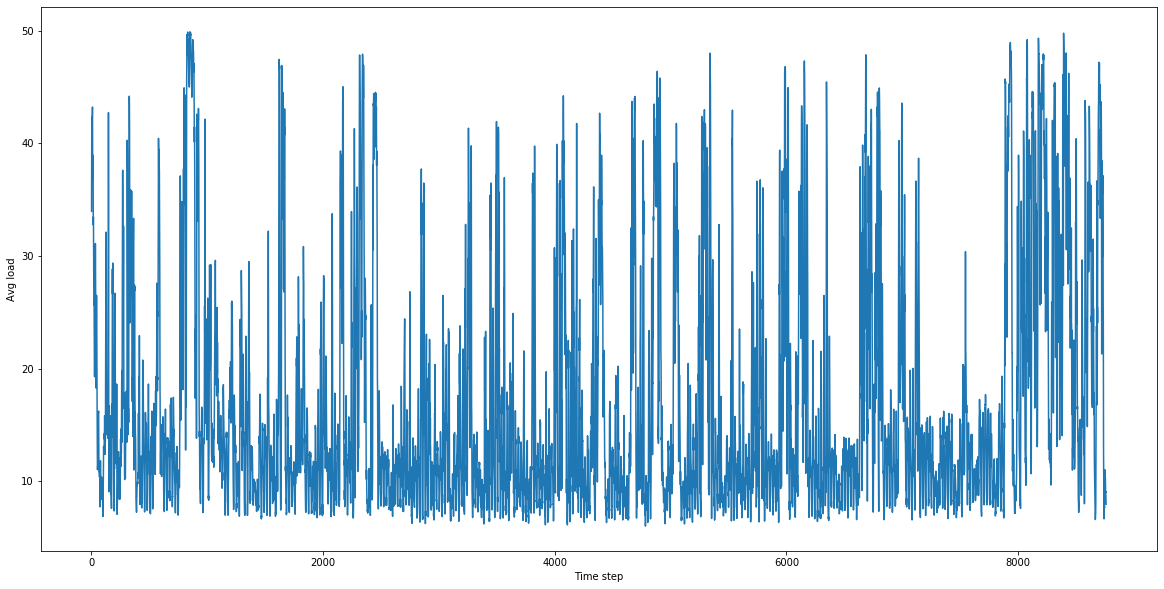

In [217]:
plt.plot(avg_load_per_timestep['Time_step'], avg_load_per_timestep['avg_load'])
plt.ylabel('Avg load')
plt.xlabel('Time step')
# datapath = os.path.join(path, "../../results/Loading plots/Avg load.png")
datapath = os.path.join(path, "../../results/Loading plots old sensis/Avg load.png")
plt.savefig(datapath)
plt.show()

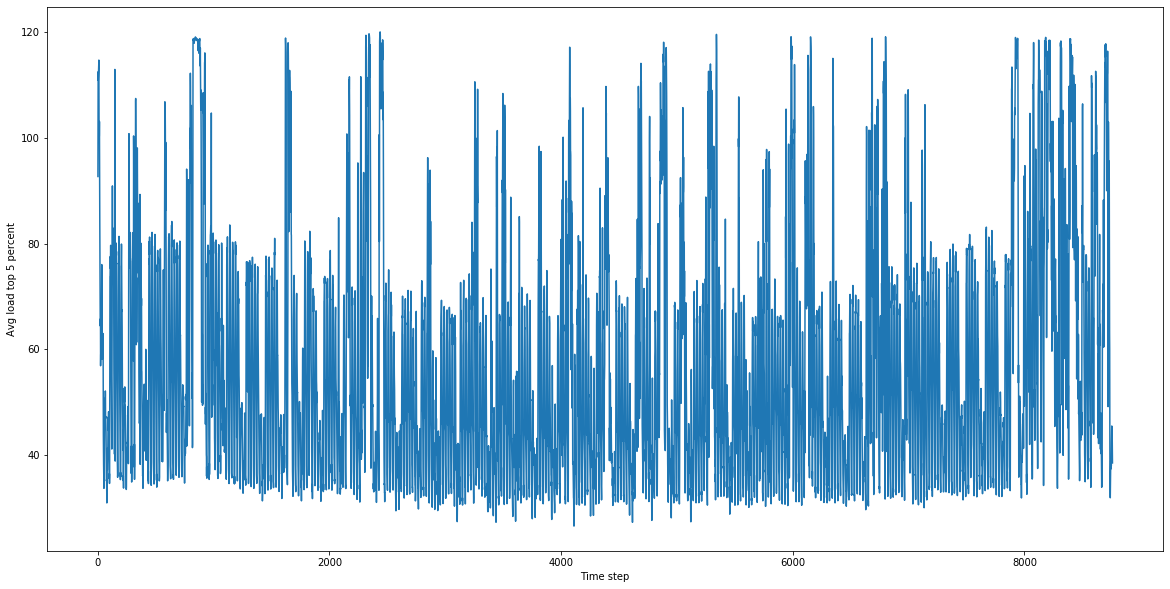

In [218]:
plt.plot(avg_load_per_timestep['Time_step'], avg_load_per_timestep['avg_load_top_5_percent'])
plt.ylabel('Avg load top 5 percent')
plt.xlabel('Time step')
# datapath = os.path.join(path, "../../results/Loading plots/Avg load top 5 percent.png")
datapath = os.path.join(path, "../../results/Loading plots old sensis/Avg load top 5 percent.png")
plt.savefig(datapath)
plt.show()

In [219]:
# overloaded.to_pickle("../../results/overloaded.pkl")
# avg_load_per_timestep.to_pickle("../../results/avg_load_per_timestep.pkl")
overloaded.to_pickle("../../results/overloaded old sensis.pkl")
avg_load_per_timestep.to_pickle("../../results/avg_load_per_timestep old sensis.pkl")

In [2]:
path = os.getcwd()
datapath = os.path.join(path, "../../inputs/Ausgabe_Zweige.pkl")
data = pd.read_pickle(datapath)
data['day'] = data['Time_step']//24

In [36]:
days = [33,34,35,36,37,38,39]

In [37]:
Lines=[]
for d in days:
    df = data.loc[data['day']==d, ['Name', 'Loading_percent']].sort_values(by='Loading_percent', ascending=False)
    try:
        Lines.append(df.loc[(df['Loading_percent'] >98) & (df['Loading_percent'] <100), 'Name'].values)
    except:
        pass
Lines = [l for array in Lines for l in array]
Lines = list(set(Lines))

In [38]:
Lines

['L_Knoten_105_Stichabgang_R_Knoten_101_Stichabgang',
 'Knoten_79_Stich_boost_1',
 'Trafo_60',
 'L_Knoten_69_Stichabgang_R_Knoten_74_boost',
 'Knoten_79_Stich',
 'L_Knoten_94_Stichabgang_R_Knoten_79_boost_boost',
 'L_29R_39',
 'L_74R_39',
 'L_0R_36_boost_1',
 'L_0R_36',
 'L_Knoten_94_Stichabgang_R_Knoten_79_boost',
 'Trafo_14',
 'L_29R_39_boost_2',
 'L_33R_39_boost',
 'L_0R_36_boost',
 'L_29R_39_boost',
 'Trafo_19',
 'L_74R_39_boost_boost',
 'Knoten_79_Stich_boost',
 'L_Knoten_69_Stichabgang_R_Knoten_74_boost_1_boost',
 'Trafo_62',
 'L_Knoten_105_Stichabgang_R_Knoten_101_Stichabgang_boost',
 'L_Knoten_94_Stichabgang_R_Knoten_79',
 'L_33R_39',
 'L_33R_39_boost_1',
 'L_0R_39',
 'L_0R_39_boost',
 'L_33R_39_boost_2',
 'L_Knoten_69_Stichabgang_R_Knoten_74',
 'L_74R_39_boost',
 'L_29R_39_boost_1',
 'L_0R_39_boost_1_boost',
 'L_Knoten_69_Stichabgang_R_Knoten_74_boost_1',
 'L_0R_39_boost_1',
 'L_74R_39_boost_boost_1']

In [39]:
data

Name  Time_step  Loading_percent    Loading_A  day
0           Trafo_HSMS          1        59.821455  2763.034634    0
142            L_39R_2          1         7.960546    25.394141    0
143           Trafo_19          1        30.557466     2.822778    0
144            L_19R_2          1         7.054566    22.504066    0
145             L_2R_2          1         7.050112    22.489859    0
...                ...        ...              ...          ...  ...
158919        Trafo_19       8761       326.326288    30.144731  365
158918         L_39R_2       8761        51.535158   164.397153  365
158917        Trafo_39       8761       224.753577    12.976154  365
158928          L_4R_3       8761        28.861115    92.066958  365
158777  Trafo_HSMS_par       8761        55.295464  2553.988100  365

[1924713 rows x 5 columns]

In [54]:
nodes = list(set(data['Name']))
Loading = np.zeros((223, 8631))
for i, node in enumerate(nodes):
    Loading[i,:]=data.loc[data['Name']==node, 'Loading_percent'].values

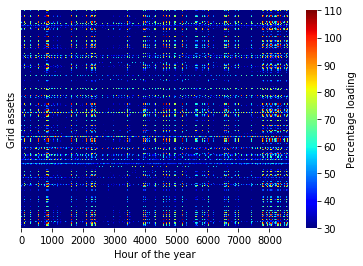

In [106]:
import seaborn as sns
ax = sns.heatmap(Loading, xticklabels=1000, yticklabels=False, cmap='jet', vmin=30, vmax=110,
                 cbar_kws={'label': 'Percentage loading'})
plt.xlabel("Hour of the year")
plt.ylabel('Grid assets')
datapath = os.path.join(path, "../../results/Grid_heatmap.png")
plt.savefig(datapath)
plt.show()

In [14]:
numMarginal = []
for d in range(366):
    df = data.loc[data['day']==d, :]
    marginal = df[(df['Loading_percent'] >98) & (df['Loading_percent'] <100)]
    numMarginal.append(len(marginal))
numMarginal = np.asarray(numMarginal)
print(numMarginal.argmax())

362


In [33]:
numMarginal

array([22,  0,  0,  0,  2,  5,  5,  3,  0,  0,  0,  7,  5, 10,  6,  1,  0,
        0,  1,  3,  2,  1,  3,  0, 19,  2,  1,  0,  1,  1,  0,  3,  0, 20,
       11,  1, 27, 18, 72,  2,  8,  0,  3,  2,  0,  0,  3,  1,  0,  0,  1,
        0,  0,  2,  3,  2,  1,  2,  0,  0,  1,  0,  1,  0,  1,  0,  0,  2,
        4, 13,  2,  1,  0,  0,  2,  3,  0,  1,  1,  0,  0,  0,  1,  0,  0,
        2,  0,  0,  3, 10, 18,  1,  1,  0,  0,  2, 18, 29,  4,  0,  0, 49,
       21,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  2,  5,
        0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  2,  3,  1,  0, 24,
        6,  0,  0,  1,  0,  0,  0, 11,  0,  5, 18,  0,  1,  0,  0,  3,  0,
        0,  0,  0,  0,  0, 15,  3,  1,  1,  0,  1,  0,  0,  0, 15,  4, 32,
       16,  0,  0,  3,  8,  0,  2,  0,  0,  0,  0,  0, 13,  4,  0,  0,  1,
        1,  0,  0,  0,  0,  0,  0, 14, 32,  1,  0, 34,  0,  0,  0, 33, 64,
       50,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  3,  0,  1,  3, 10, 15,
       10, 15,  1,  0,  0

In [16]:
df = data.loc[data['day']==362, :]

In [31]:
d=data[(data['Name']=='Trafo_33')&(data['Time_step']==8690)]

In [32]:
d

Name  Time_step  Loading_percent  Loading_A  day
25257  Trafo_33       8690         22.96362   5.303221  362

In [35]:
numMarginal[40]

8